# Hotel Recommendation

## Business Understanding

## Data Understanding

In [71]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("dataset-1-labeled-merged.csv")
data

,cheap,luxurious,clean,cozy,good service,nice view,parking,pool,spa,gym,...,breakfast,safety,family,pet,aesthetic,disability,laundry,id,text,text_id
0,0,1,1,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,"This hotel was nice and quiet. Did not know, t...","Hotel ini bagus dan tenang. Tidak tahu, ada re..."
1,1,1,1,1,1,1,0,0,0,0,...,0,1,1,0,1,1,0,1,We stayed in the king suite with the separatio...,Kami menginap di suite king dengan pemisah ant...


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9889 entries, 0 to 9888
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cheap         9889 non-null   int64 
 1   luxurious     9889 non-null   int64 
 2   clean         9889 non-null   int64 
 3   cozy          9889 non-null   int64 
 4   good service  9889 non-null   int64 
 5   nice view     9889 non-null   int64 
 6   parking       9889 non-null   int64 
 7   pool          9889 non-null   int64 
 8   spa           9889 non-null   int64 
 9   gym           9889 non-null   int64 
 10  wifi          9889 non-null   int64 
 11  strategic     9889 non-null   int64 
 12  delicious     9889 non-null   int64 
 13  breakfast     9889 non-null   int64 
 14  safety        9889 non-null   int64 
 15  family        9889 non-null   int64 
 16  pet           9889 non-null   int64 
 17  aesthetic     9889 non-null   int64 
 18  disability    9889 non-null   int64 
 19  laundr

In [74]:
print(data.columns)

Index(['cheap', 'luxurious', 'clean', 'cozy', 'good service', 'nice view',
       'parking', 'pool', 'spa', 'gym', 'wifi', 'strategic', 'delicious',
       'breakfast', 'safety', 'family', 'pet', 'aesthetic', 'disability',
       'laundry', 'id', 'text', 'text_id'],
      dtype='object')


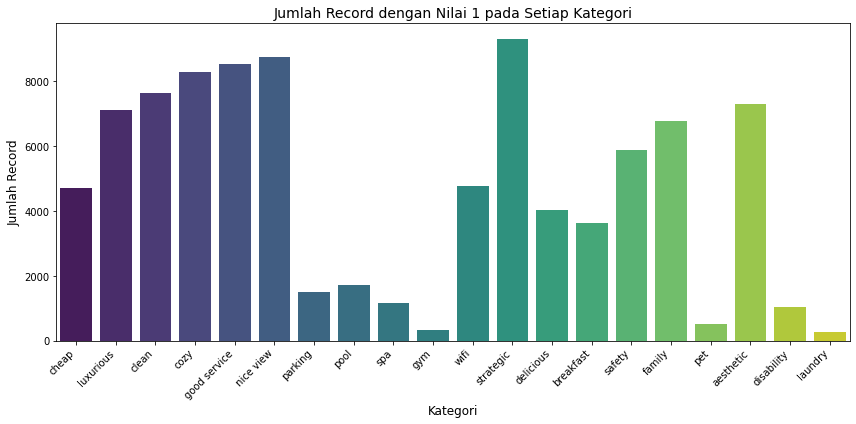

In [75]:


# Memilih kolom kategori dari cheap hingga laundry
category_columns = ['cheap', 'luxurious', 'clean', 'cozy', 'good service', 'nice view', 'parking', 'pool', 'spa', 'gym', 'wifi', 'strategic', 'delicious', 'breakfast', 'safety', 'family', 'pet', 'aesthetic', 'disability', 'laundry']

# Menghitung jumlah nilai 1 di setiap kategori
category_counts = data[category_columns].sum()

# Membuat DataFrame untuk visualisasi
category_df = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts.values})

# Membuat visualisasi
plt.figure(figsize=(12, 6))
sns.barplot(data=category_df, x='Category', y='Count', palette='viridis')

# Menambahkan judul dan label
plt.title('Jumlah Record dengan Nilai 1 pada Setiap Kategori', fontsize=14)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Record', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Data Preparation

In [76]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Normalization dictionary (contoh)
kamus_slang = pd.read_excel('combined_slang_words.xlsx')
slang_dict = dict(zip(kamus_slang['Kunci'], kamus_slang['Nilai']))

# Preprocessing function
def preprocess_text(text):
    # 1. Case folding
    text = text.lower()
    
    # 2. Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    
    # 3. Tokenizing
    tokens = word_tokenize(text)
    
    # 4. Normalization
    tokens = [slang_dict.get(word, word) for word in tokens]
    
    # 5. Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # 6. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back to text
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
# Preprocess all texts in the dataset
data['text_id'] = data['text_id'].astype(str)
data['processed_text'] = data['text_id'].apply(preprocess_text)

# Pilih teks yang sudah diproses
texts = data['processed_text'].astype(str).tolist()

# Label tetap sama seperti sebelumnya
labels = data[['cheap', 'luxurious', 'clean', 'cozy', 'good service', 'nice view','parking', 'pool', 'spa', 'gym', 'wifi', 'strategic', 'delicious', 'breakfast', 'safety', 'family', 'pet', 'aesthetic', 'disability', 'laundry']].values

## Modelling

In [79]:
VOCAB_SIZE = 5000
MAX_LENGTH = 100
OOV_TOKEN = "<OOV>"
EPOCHS = 50
BATCH_SIZE = 256

In [80]:
# Tokenisasi
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [81]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Shape data training: {X_train.shape}, Shape data testing: {X_test.shape}")

Shape data training: (7911, 100), Shape data testing: (1978, 100)


In [82]:
# Bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 16, input_length=MAX_LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(labels.shape[1], activation='sigmoid')  # Aktivasi sigmoid untuk multilabel
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 16)           80000     
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_19 (Dense)            (None, 64)                1088      
                                                                 
 dense_20 (Dense)            (None, 20)                1300      
                                                                 
Total params: 82,388
Trainable params: 82,388
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Latih model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/50
31/31 [==============================] - 2s 16ms/step - loss: 0.6781 - accuracy: 0.0279 - val_loss: 0.6555 - val_accuracy: 0.0283
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6138 - accuracy: 0.0240 - val_loss: 0.5601 - val_accuracy: 0.0283
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.5091 - accuracy: 0.0240 - val_loss: 0.4787 - val_accuracy: 0.0283
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.4625 - accuracy: 0.0282 - val_loss: 0.4635 - val_accuracy: 0.0334
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.4544 - accuracy: 0.0364 - val_loss: 0.4598 - val_accuracy: 0.0334
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.4513 - accuracy: 0.0364 - val_loss: 0.4568 - val_accuracy: 0.0334
Epoch 7/50
31/31 [==============================] - 0s 7ms/step - loss: 0.4481 - accuracy: 0.0364 - val_loss: 0.4531 - val_accuracy: 0.0334
Epoch 8/50
31/31 [=

## Evaluation

In [84]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


62/62 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.0354
Loss: 0.3587011694908142, Accuracy: 0.03538928180932999


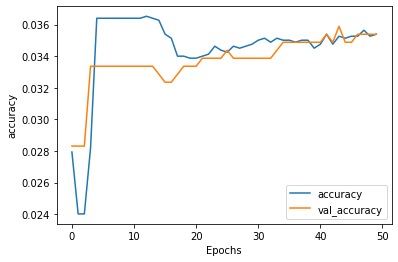

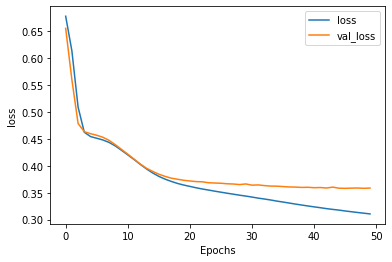

In [85]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [86]:
from sklearn.metrics import classification_report

# Prediksi
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Konversi probabilitas menjadi binary

# Evaluasi
print(classification_report(y_test, y_pred_binary, target_names=['cheap', 'luxurious', 'clean', 'cozy', 'good service', 'nice view', 'parking', 'pool', 'spa', 'gym', 'wifi', 'strategic', 'delicious', 'breakfast', 'safety', 'family',  'pet', 'aesthetic', 'disability', 'laundry']))

62/62 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       cheap       0.65      0.68      0.66       918
   luxurious       0.85      0.92      0.89      1383
       clean       0.89      0.94      0.91      1513
        cozy       0.92      0.96      0.94      1633
good service       0.92      0.97      0.94      1679
   nice view       0.92      0.97      0.95      1726
     parking       0.57      0.27      0.37       307
        pool       0.68      0.30      0.41       328
         spa       0.38      0.06      0.10       225
         gym       0.00      0.00      0.00        71
        wifi       0.70      0.71      0.71       913
   strategic       0.93      1.00      0.97      1845
   delicious       0.66      0.64      0.65       796
   breakfast       0.75      0.54      0.63       733
      safety       0.69      0.74      0.72      1183
      family       0.76      0.88      0.82      1334
         pet       0.50     

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Deployment

In [87]:
# Prediksi pada teks baru
new_text = ["Hotelnya sangat bersih, murah, dan lokasinya strategis"]
new_sequences = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_sequences, maxlen=MAX_LENGTH, padding='post')
predictions = model.predict(new_padded)

# Output probabilitas tiap label
for idx, label in enumerate(['cheap', 'luxurious', 'clean', 'cozy', 'good service', 'nice view', 'parking', 'pool', 'spa', 'gym', 'wifi', 'strategic', 'delicious', 'breakfast', 'safety', 'family', 'pet', 'aesthetic', 'disability', 'laundry']):
    print(f"{label}: {predictions[0][idx]:.2f}")

1/1 [==============================] - 0s 27ms/step
cheap: 0.52
luxurious: 0.67
clean: 0.80
cozy: 0.84
good service: 0.92
nice view: 0.87
parking: 0.05
pool: 0.05
spa: 0.05
gym: 0.01
wifi: 0.20
strategic: 0.94
delicious: 0.31
breakfast: 0.18
safety: 0.34
family: 0.45
pet: 0.02
aesthetic: 0.52
disability: 0.02
laundry: 0.00


In [ ]:
model.save("multilabel_text_classification_tf_model.h5")